# M5 Forecasting Challenge

# Author - Stacy Liu

### Objective:
- Predict sales data provided by Walmart 28 days into the future
- Estimate the uncertainty of prediction

### Data:
- sales_train.csv: historical daily unit sales data in three US States (CA, TX, WI) at the item, department, product category, and store level; 1 column for each of the 1941 days from 1/29/2011 to 5/22/2016; 30490 rows for all combinations of 3049 items and 10 stores
- sell_prices.csv: Weekly average sale price of items at the item, store level
- calendar.csv: dates with related features like day of the week, month, year, and 3 flags for whether the stores in each state allowed purchases with SNAP food stamps at this date or not

## Initial Data Exploration

In [42]:
# Import libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

In [2]:
# Load data
filename = r"C:\Users\19173\Desktop\Kaggle\M5 Forecasting Accuracy\Data\m5-forecasting-accuracy\sales_train_validation.csv"
sales_train = pd.read_csv(filename)
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


sales_train data structure:
- One column each for IDs of item, dept, category, store, and state
- One general ID column that's a combination of the other IDs
- Sales per date (units sold) is encoded as columns starting with prefix d_
- Lot of zero values

In [3]:
print(sales_train.shape)
print(sales_train.dtypes)

(30490, 1919)
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object


## Exploratory Data Analysis

#### Visualizing data for a single item

In [4]:
#sales data columns
d_cols=[c for c in sales_train.columns if 'd_' in c]

<function matplotlib.pyplot.show(*args, **kw)>

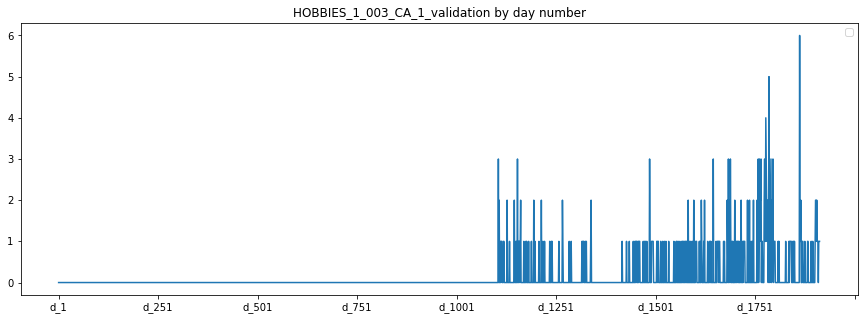

In [5]:
#select the item
sales_train.loc[sales_train['id'] == 'HOBBIES_1_003_CA_1_validation'] \
.set_index('id')[d_cols] \
.T \
.plot(figsize=(15,5),
      title='HOBBIES_1_003_CA_1_validation by day number')
plt.legend('')
plt.show

At the granular  level, the data is sporatic with lots of 0

#### Total Sales

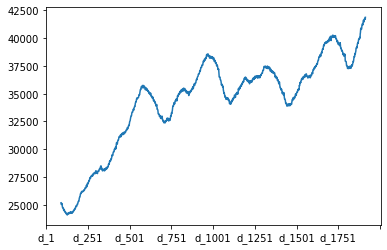

In [6]:
total_sales=sales_train.sum(axis=0, skipna = True, numeric_only = True)
total_sales.head(20)
total_sales.T.rolling(90).mean().plot()

#### Sales by State

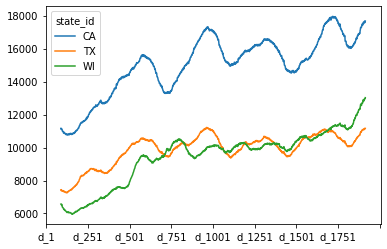

In [7]:
state_sales=sales_train.groupby('state_id').agg('sum')
state_sales.T.rolling(90).mean().plot()

A rolling 90 day sales by state shows that sales for all three States have been increasing from 2011 to 2016
- CA sold the most amout of items during the entire 5 year period
- WI overtook TX in terms of the number of the items sold around day 1600
- There's some seasonality at play here with sales reaching a local max every 300-400 days 

In [8]:
state_sales=sales_train.groupby(['state_id'], as_index=False).agg('sum')
state_sales.head(20)

,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,16255,20564,23032,17052,15784,15148,14488,17095,21834,23187
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,10800,12460,13709,9868,10922,9600,9602,10615,12266,12282
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,14734,15338,14899,11139,10864,10595,10943,12807,14862,14326


#### Sales by Store ID

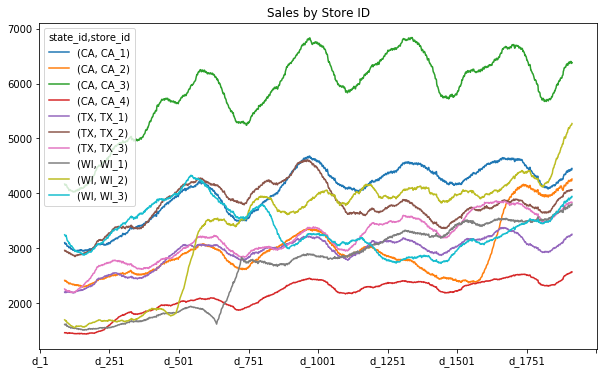

In [9]:
store_id_sales=sales_train.groupby(['state_id','store_id']).agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
store_id_sales.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID')
plt.show()

In [10]:
store_sales=sales_train.groupby(['store_id','state_id'], as_index=False).agg('sum')
store_sales.head(20)

,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA_1,CA,4337,4155,2816,3051,2630,3276,3450,5437,...,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
1,CA_2,CA,3494,3046,2121,2324,1942,2288,2629,3729,...,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
2,CA_3,CA,4739,4827,3785,4232,3817,4369,4703,5456,...,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
3,CA_4,CA,1625,1777,1386,1440,1536,1389,1469,1988,...,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
4,TX_1,TX,2556,2687,1822,2258,1694,2734,1691,2820,...,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033
5,TX_2,TX,3852,3937,2731,2954,2492,3439,2588,3772,...,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292
6,TX_3,TX,3030,3006,2225,2169,1726,2833,1947,2848,...,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957
7,WI_1,WI,2704,2194,1562,1251,2,2049,2815,3248,...,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
8,WI_2,WI,2256,1922,2018,2522,1175,2244,2232,2643,...,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127
9,WI_3,WI,4038,4198,3317,3211,2132,4590,4486,5991,...,4613,4897,4521,3556,3331,3159,3226,3828,4686,4325


Look at a single State

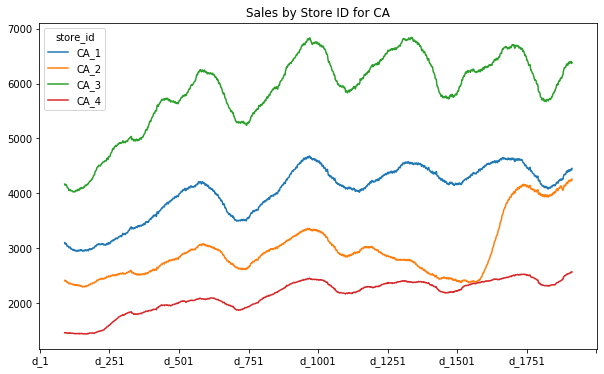

In [11]:
ca_sales=sales_train.loc[sales_train['state_id']=='CA']
ca_sales_by_store=ca_sales.groupby('store_id').agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
ca_sales_by_store.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID for CA')
plt.show()

- CA has four stores with store 3 always having highest sales
- CA_1 and CA_4 had comparably flatter growth
- CA_3 had a long decline, followed by steep increase at around day 1550

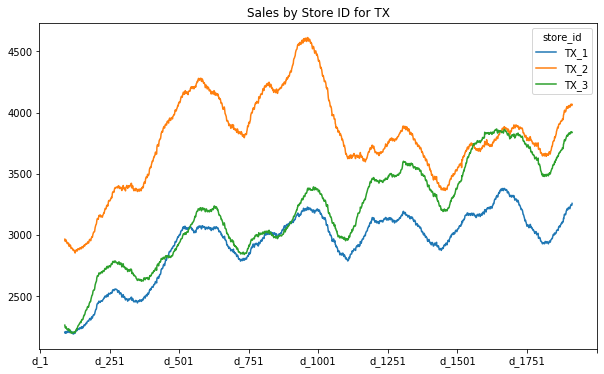

In [12]:
tx_sales=sales_train.loc[sales_train['state_id']=='TX']
tx_sales_by_store=tx_sales.groupby('store_id').agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
tx_sales_by_store.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID for TX')
plt.show()

- Around day 1000, all three TX stores had a steep decline in sales, especially so for store TX_2

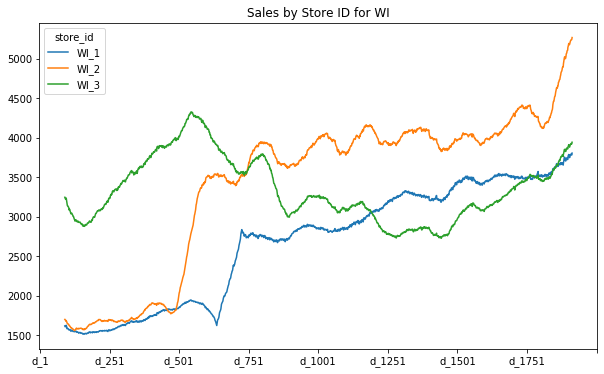

In [13]:
wi_sales=sales_train.loc[sales_train['state_id']=='WI']
wi_sales_by_store=wi_sales.groupby('store_id').agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
wi_sales_by_store.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID for WI')
plt.show()

- WI_1 and WI_2 saw steep growth in sales after slower beginnng
- WI_3 sale started declining when WI_1 and WI_2 began growing

#### Sales by Category

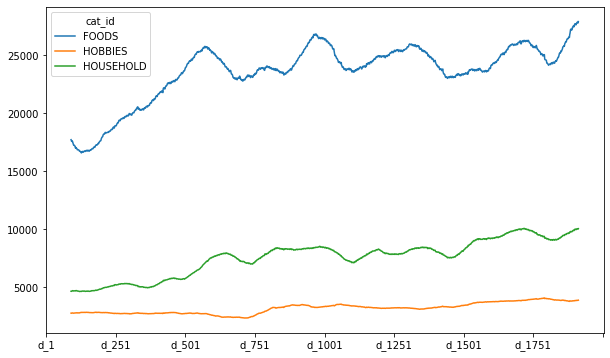

In [14]:
cat_sales=sales_train.groupby(['cat_id']).agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
cat_sales.T.rolling(90).mean().plot(ax=ax)

Food has the highest unit sales during this period, followed by household items, and lastly hobbies

In [15]:
cat_sales=sales_train.groupby(['cat_id','store_id','state_id'], as_index=False).agg('sum')
cat_sales.head(20)

,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS,CA_1,CA,3239,3137,2008,2258,2032,2407,2693,...,2706,3481,4004,2886,2488,2490,2533,2960,3655,4053
1,FOODS,CA_2,CA,2193,1921,1289,1540,1278,1494,1785,...,2891,3423,3729,2625,2410,2506,2261,2871,3760,4012
2,FOODS,CA_3,CA,3446,3535,2701,3064,2761,3340,3455,...,3471,4307,5127,3827,3468,3286,3056,3409,4459,4698
3,FOODS,CA_4,CA,1223,1269,946,1002,1107,1015,1072,...,1664,1883,1995,1879,1722,1581,1629,1751,1971,2043
4,FOODS,TX_1,TX,1781,1903,1377,1643,1329,2091,1247,...,2049,2412,2629,2434,2113,1834,1777,1922,2319,2491
5,FOODS,TX_2,TX,2788,2870,2082,2180,1890,2696,1963,...,2549,2795,3221,2268,2440,2196,2239,2547,2930,2853
6,FOODS,TX_3,TX,2284,2257,1665,1647,1383,2280,1461,...,2396,2737,2867,2132,2513,2212,2151,2370,2600,2421
7,FOODS,WI_1,WI,1581,1327,977,935,2,1278,1671,...,2700,3195,3501,2282,2135,2290,2285,2790,3242,3317
8,FOODS,WI_2,WI,1615,1433,1586,2013,967,1709,1668,...,4836,4175,4157,3206,3282,3005,3078,3419,3751,3659
9,FOODS,WI_3,WI,3028,3106,2543,2596,1854,3783,3475,...,3420,3599,3267,2612,2377,2232,2308,2665,3240,3107


#### Sales by Dept

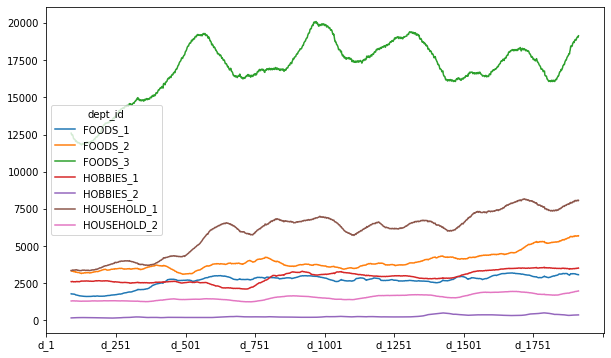

In [16]:
agg_dept_sales=sales_train.groupby(['dept_id']).agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
agg_dept_sales.T.rolling(90).mean().plot(ax=ax)

In particular FOODS_3 has much higher sales than any other department

In [17]:
dept_sales=sales_train.groupby(['dept_id','cat_id','store_id','state_id'], as_index=False).agg('sum')
dept_sales.head(20)

,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1,FOODS,CA_1,CA,297,284,214,175,182,191,...,293,317,268,302,237,287,297,331,419,329
1,FOODS_1,FOODS,CA_2,CA,406,408,238,240,220,263,...,535,504,515,327,366,422,334,579,623,520
2,FOODS_1,FOODS,CA_3,CA,341,326,260,231,220,258,...,420,500,457,301,331,306,276,335,510,423
3,FOODS_1,FOODS,CA_4,CA,113,124,75,97,107,84,...,284,241,193,196,185,201,190,229,250,257
4,FOODS_1,FOODS,TX_1,TX,152,154,109,126,108,153,...,204,244,245,193,138,176,198,201,218,221
5,FOODS_1,FOODS,TX_2,TX,210,169,159,107,128,185,...,249,254,249,220,227,221,207,235,280,220
6,FOODS_1,FOODS,TX_3,TX,138,123,113,84,61,107,...,277,298,242,176,248,247,302,259,250,209
7,FOODS_1,FOODS,WI_1,WI,343,306,208,145,0,297,...,281,340,334,268,286,282,301,339,430,342
8,FOODS_1,FOODS,WI_2,WI,191,184,154,205,96,189,...,437,537,383,301,320,335,307,400,408,347
9,FOODS_1,FOODS,WI_3,WI,152,138,127,98,87,170,...,212,288,176,177,206,180,227,261,324,317


In [18]:
print(dept_sales.shape)

(70, 1917)


dept_sales aggregated the sales data at the dept level (70 rows by 1913 columns)

### Merging sales data with calendar data

In [19]:
# Load data
filename = r"C:\Users\19173\Desktop\Kaggle\M5 Forecasting Accuracy\Data\m5-forecasting-accuracy\calendar.csv"
calendar = pd.read_csv(filename)
calendar['date']=pd.to_datetime(calendar['date'])
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [20]:
calendar['d']=calendar['d'].str[2:]
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,1968,NaN,NaN,NaN,NaN,0,0,0


In [21]:
calendar['d']=calendar['d'].astype(int)
calendar['event_name_1']=calendar['event_name_1'].astype(str)
calendar['event_name_2']=calendar['event_name_2'].astype(str)
calendar['event_type_1']=calendar['event_type_1'].astype(str)
calendar['event_type_2']=calendar['event_type_2'].astype(str)
calendar.dtypes

date            datetime64[ns]
wm_yr_wk                 int64
weekday                 object
wday                     int64
month                    int64
year                     int64
d                        int32
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
snap_CA                  int64
snap_TX                  int64
snap_WI                  int64
dtype: object

In [22]:
dept_sales_transpose=pd.wide_to_long(dept_sales, stubnames='d_', i=['dept_id','cat_id','store_id','state_id'], j='day').reset_index()
dept_sales_transpose.rename(columns={'d_':'sales'}, inplace=True)
dept_sales_transpose.tail(20)

,dept_id,cat_id,store_id,state_id,day,sales
133890,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1894,116
133891,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1895,124
133892,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1896,127
133893,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1897,168
133894,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1898,206
133895,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1899,225
133896,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1900,155
133897,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1901,133
133898,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1902,122
133899,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1903,125


In [23]:
dept_sales_transpose.shape

(133910, 6)

In [24]:
dept_sales_merged=pd.merge(dept_sales_transpose,calendar, left_on='day', right_on='d', how='left')

In [25]:
dept_sales_merged

,dept_id,cat_id,store_id,state_id,day,sales,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_1,FOODS,CA_1,CA,1,297,2011-01-29,11101,Saturday,1,1,2011,1,nan,nan,nan,nan,0,0,0
1,FOODS_1,FOODS,CA_1,CA,2,284,2011-01-30,11101,Sunday,2,1,2011,2,nan,nan,nan,nan,0,0,0
2,FOODS_1,FOODS,CA_1,CA,3,214,2011-01-31,11101,Monday,3,1,2011,3,nan,nan,nan,nan,0,0,0
3,FOODS_1,FOODS,CA_1,CA,4,175,2011-02-01,11101,Tuesday,4,2,2011,4,nan,nan,nan,nan,1,1,0
4,FOODS_1,FOODS,CA_1,CA,5,182,2011-02-02,11101,Wednesday,5,2,2011,5,nan,nan,nan,nan,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133905,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1909,148,2016-04-20,11612,Wednesday,5,4,2016,1909,nan,nan,nan,nan,0,0,0
133906,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1910,142,2016-04-21,11612,Thursday,6,4,2016,1910,nan,nan,nan,nan,0,0,0
133907,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1911,166,2016-04-22,11612,Friday,7,4,2016,1911,nan,nan,nan,nan,0,0,0
133908,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1912,232,2016-04-23,11613,Saturday,1,4,2016,1912,nan,nan,nan,nan,0,0,0


Clean data types

In [26]:
dept_sales_merged['event_name_1']=dept_sales_merged['event_name_1'].astype(str)
dept_sales_merged['event_name_2']=dept_sales_merged['event_name_2'].astype(str)
dept_sales_merged['event_type_1']=dept_sales_merged['event_type_1'].astype(str)
dept_sales_merged['event_type_2']=dept_sales_merged['event_type_2'].astype(str)
dept_sales_merged.dtypes

dept_id                 object
cat_id                  object
store_id                object
state_id                object
day                      int64
sales                    int64
date            datetime64[ns]
wm_yr_wk                 int64
weekday                 object
wday                     int64
month                    int64
year                     int64
d                        int32
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
snap_CA                  int64
snap_TX                  int64
snap_WI                  int64
dtype: object

Add flag for days with event

In [27]:
dept_sales_merged['event_flag']=[1 if x!='nan' else 0 for x in dept_sales_merged['event_name_1']]
dept_sales_merged

,dept_id,cat_id,store_id,state_id,day,sales,date,wm_yr_wk,weekday,wday,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,event_flag
0,FOODS_1,FOODS,CA_1,CA,1,297,2011-01-29,11101,Saturday,1,...,2011,1,nan,nan,nan,nan,0,0,0,0
1,FOODS_1,FOODS,CA_1,CA,2,284,2011-01-30,11101,Sunday,2,...,2011,2,nan,nan,nan,nan,0,0,0,0
2,FOODS_1,FOODS,CA_1,CA,3,214,2011-01-31,11101,Monday,3,...,2011,3,nan,nan,nan,nan,0,0,0,0
3,FOODS_1,FOODS,CA_1,CA,4,175,2011-02-01,11101,Tuesday,4,...,2011,4,nan,nan,nan,nan,1,1,0,0
4,FOODS_1,FOODS,CA_1,CA,5,182,2011-02-02,11101,Wednesday,5,...,2011,5,nan,nan,nan,nan,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133905,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1909,148,2016-04-20,11612,Wednesday,5,...,2016,1909,nan,nan,nan,nan,0,0,0,0
133906,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1910,142,2016-04-21,11612,Thursday,6,...,2016,1910,nan,nan,nan,nan,0,0,0,0
133907,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1911,166,2016-04-22,11612,Friday,7,...,2016,1911,nan,nan,nan,nan,0,0,0,0
133908,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1912,232,2016-04-23,11613,Saturday,1,...,2016,1912,nan,nan,nan,nan,0,0,0,0


### Time Series EDA

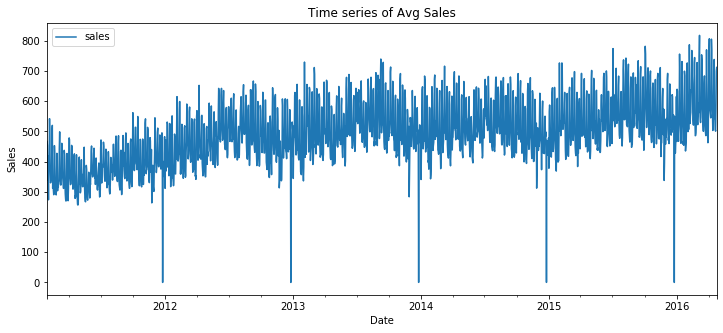

In [28]:
sales_merged_all=dept_sales_merged.groupby(['date'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all.plot(x='date',y='sales', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales')
plt.show()

In [88]:
sales_merged_all.head()

,date,day,sales,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,event_flag
0,2011-01-29,1.0,466.157143,11101.0,1.0,1.0,2011.0,1,0.0,0.0,0.0,0.0
1,2011-01-30,2.0,453.557143,11101.0,2.0,1.0,2011.0,2,0.0,0.0,0.0,0.0
2,2011-01-31,3.0,339.757143,11101.0,3.0,1.0,2011.0,3,0.0,0.0,0.0,0.0
3,2011-02-01,4.0,363.028571,11101.0,4.0,2.0,2011.0,4,1.0,1.0,0.0,0.0
4,2011-02-02,5.0,273.514286,11101.0,5.0,2.0,2011.0,5,1.0,0.0,1.0,0.0


In [29]:
zero_sales = sales_merged_all.loc[sales_merged_all['sales'] < 10]
zero_sales

,date,day,sales,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,event_flag
330,2011-12-25,331.0,0.185714,11148.0,2.0,12.0,2011.0,331,0.0,0.0,0.0,1.0
696,2012-12-25,697.0,0.157143,11248.0,4.0,12.0,2012.0,697,0.0,0.0,0.0,1.0
1061,2013-12-25,1062.0,0.285714,11348.0,5.0,12.0,2013.0,1062,0.0,0.0,0.0,1.0
1426,2014-12-25,1427.0,0.285714,11447.0,6.0,12.0,2014.0,1427,0.0,0.0,0.0,1.0
1791,2015-12-25,1792.0,0.200000,11547.0,7.0,12.0,2015.0,1792,0.0,0.0,0.0,1.0


Walmart sales has been increasing from 2012 to 2016. The one day every year where we see close to zero sales is Christmas when stores are closed.

#### Sales by Event

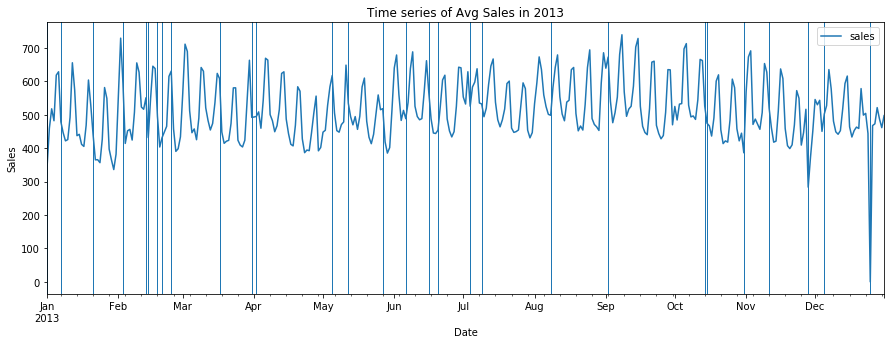

In [30]:
sales_merged_all_2013=sales_merged_all.loc[sales_merged_all['date'].dt.year==2013]
ax = plt.figure(figsize=(15, 5)).gca()
sales_merged_all_2013.plot(x='date',y='sales', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales in 2013')
for _, e in calendar.loc[calendar['event_name_1']!='nan'].iterrows():
    ax.axvline(linewidth=1, x=e['date'])
plt.show()

Plotting sales with events annotated as vertical lines shows us there's some relationship between sales and event. 

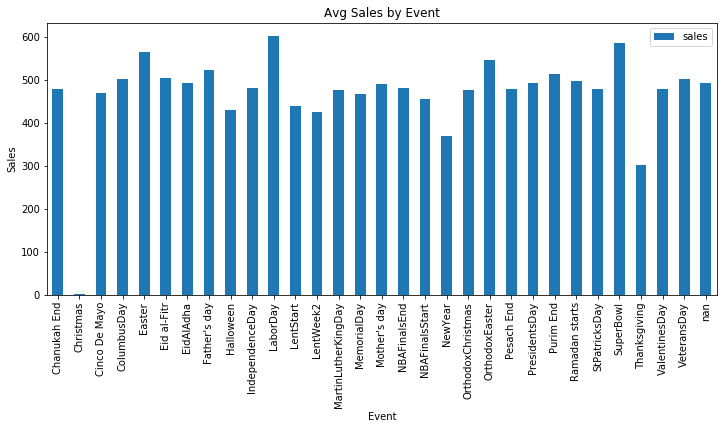

In [31]:
sales_merged_event=dept_sales_merged.groupby(['event_name_1'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_event.plot.bar(x='event_name_1',y='sales', ax=ax)
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by Event')
plt.show()

Labor Day and Superbowl appears to have much higher sales than no event days. Is there a dept/cat that is driving the higher sale?

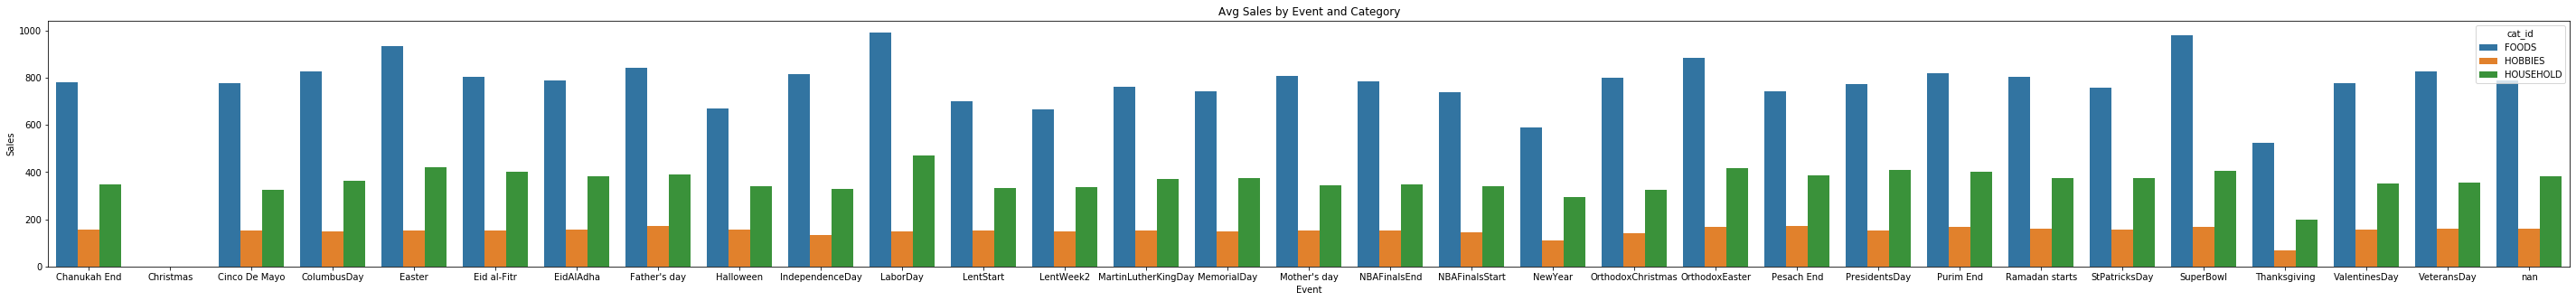

In [32]:
sales_merged_event_cat=dept_sales_merged.groupby(['event_name_1','cat_id'], as_index=False).mean()
ax = plt.figure(figsize=(50, 5)).gca()
sns.barplot(x='event_name_1',y='sales', hue='cat_id', ax=ax, data=sales_merged_event_cat)
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by Event and Category')
plt.show()

- Hobbies does not have much variation between events
- Food appears to be driving high avg sales on event days, in particular for Labor Day and Superbowl
- Where we are seeing peaks in Food sale, we are also seeing bump in household item sales

# Open Q: For events, perhaps sale happens before the actual event? look at sales +3

In [33]:
sales_merged_all

,date,day,sales,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,event_flag
0,2011-01-29,1.0,466.157143,11101.0,1.0,1.0,2011.0,1,0.0,0.0,0.0,0.0
1,2011-01-30,2.0,453.557143,11101.0,2.0,1.0,2011.0,2,0.0,0.0,0.0,0.0
2,2011-01-31,3.0,339.757143,11101.0,3.0,1.0,2011.0,3,0.0,0.0,0.0,0.0
3,2011-02-01,4.0,363.028571,11101.0,4.0,2.0,2011.0,4,1.0,1.0,0.0,0.0
4,2011-02-02,5.0,273.514286,11101.0,5.0,2.0,2011.0,5,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,1909.0,504.900000,11612.0,5.0,4.0,2016.0,1909,0.0,0.0,0.0,0.0
1909,2016-04-21,1910.0,500.471429,11612.0,6.0,4.0,2016.0,1910,0.0,0.0,0.0,0.0
1910,2016-04-22,1911.0,578.814286,11612.0,7.0,4.0,2016.0,1911,0.0,0.0,0.0,0.0
1911,2016-04-23,1912.0,699.457143,11613.0,1.0,4.0,2016.0,1912,0.0,0.0,0.0,0.0


#### Sales by Food Stamp Flag

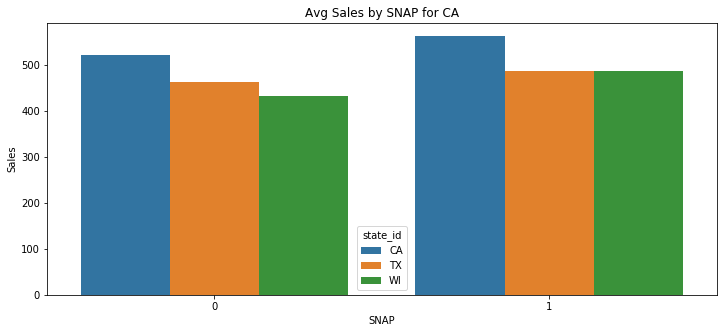

In [34]:
sales_merged_cafoodstamp=dept_sales_merged.groupby(['snap_CA' , 'state_id'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='snap_CA',y='sales', hue='state_id', ax=ax, data=sales_merged_cafoodstamp)
ax.set_xlabel('SNAP')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by SNAP for CA')
plt.show()

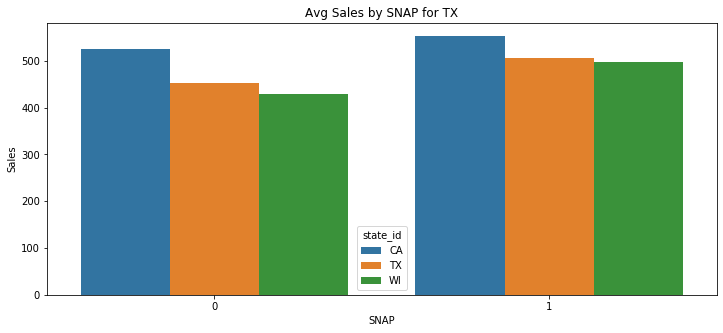

In [35]:
sales_merged_txfoodstamp=dept_sales_merged.groupby(['snap_TX' , 'state_id'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='snap_TX',y='sales', hue='state_id', ax=ax, data=sales_merged_txfoodstamp)
ax.set_xlabel('SNAP')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by SNAP for TX')
plt.show()

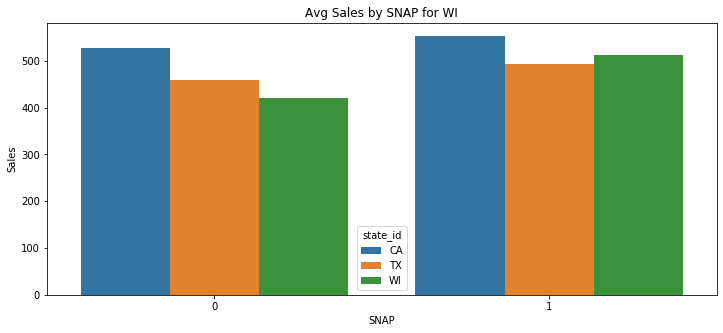

In [36]:
sales_merged_wifoodstamp=dept_sales_merged.groupby(['snap_WI' , 'state_id'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='snap_WI',y='sales', hue='state_id', ax=ax, data=sales_merged_wifoodstamp)
ax.set_xlabel('SNAP')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by SNAP for WI')
plt.show()

In all 3 States, SNAP days generated larger sales

#### Sales by day of the week

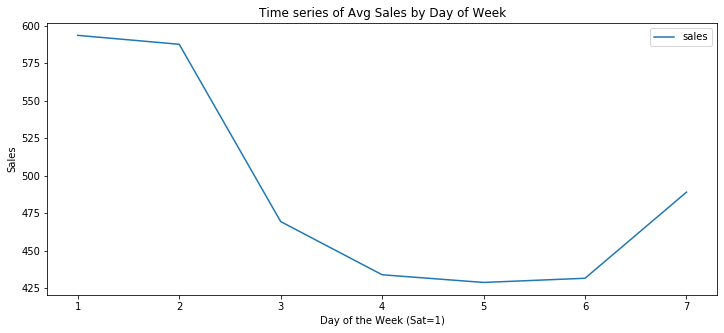

In [37]:
sales_merged_all_dayofweek=dept_sales_merged.groupby(['wday'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all_dayofweek.plot(x='wday',y='sales', ax=ax)
ax.set_xlabel('Day of the Week (Sat=1)')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales by Day of Week')
plt.show()

Sales were the highest on the weekend (fri-sun)

#### Sales by Month

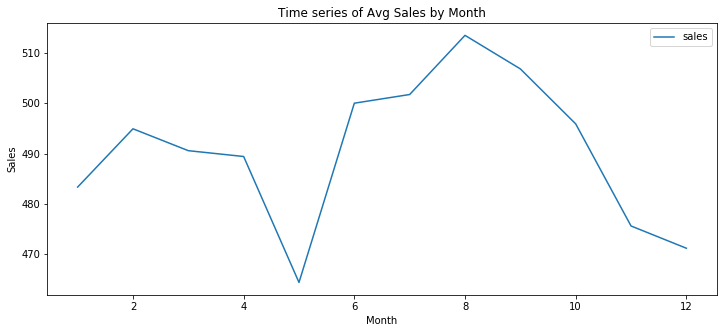

In [38]:
sales_merged_all_month=dept_sales_merged.groupby(['month'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all_month.plot(x='month',y='sales', ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales by Month')
plt.show()

Sales peaked in the summer months (June-Oct).

#### Sales by Year

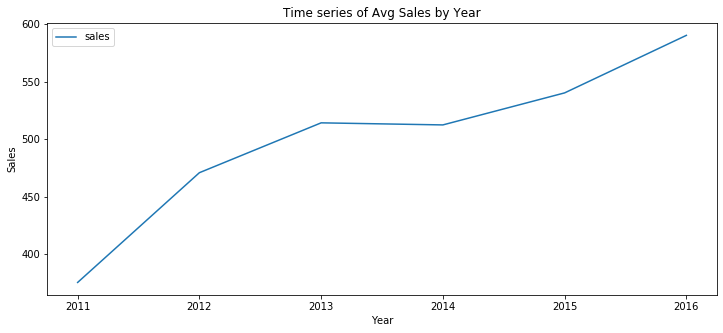

In [39]:
sales_merged_all_year=dept_sales_merged.groupby(['year'], as_index=False).mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all_year.plot(x='year',y='sales', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales by Year')
plt.show()

Sales has been increasing since 2011.

#### Sales by State

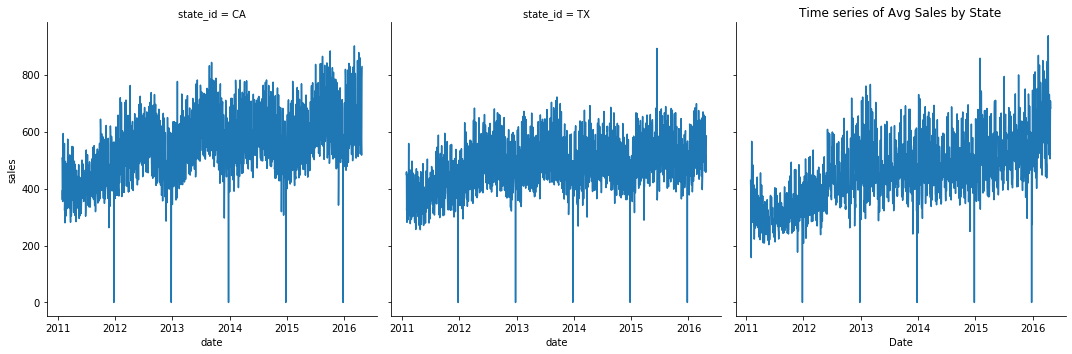

In [40]:
state_sales_merged=dept_sales_merged.groupby(['date','state_id'], as_index=False).mean()
sns.relplot(x = 'date', y = 'sales', 
           data = state_sales_merged, 
           col = "state_id",
           kind='line')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Time series of Avg Sales by State')
plt.show()

Similiar trend across States

# Forecasting using Prophet

In [147]:
#install package
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

### Use Prophet to forecast avg sales
Format data to fit Prophet

In [152]:
train_data=sales_merged_all[['date','sales']].copy()
train_data.rename(columns={"date":'ds', "sales":"y"}, inplace=True)

In [172]:
train_data

,ds,y
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0
...,...,...
1908,2016-04-20,1
1909,2016-04-21,0
1910,2016-04-22,1
1911,2016-04-23,1


In [173]:
model = Prophet() #instantiate Prophet
model.fit(train_data) #fit the model with your dataframe

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [174]:
future_data=model.make_future_dataframe(periods=100)

In [175]:
forecast_data=model.predict(future_data)

In [176]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2003,2016-07-24,0.755161,0.231761,1.315221
2004,2016-07-25,0.706762,0.117839,1.253626
2005,2016-07-26,0.721493,0.165001,1.291076
2006,2016-07-27,0.724878,0.155594,1.276133
2007,2016-07-28,0.742440,0.162285,1.235297
2008,2016-07-29,0.785061,0.223291,1.349250
2009,2016-07-30,0.863511,0.301759,1.452673
2010,2016-07-31,0.776809,0.260853,1.368865
2011,2016-08-01,0.724502,0.114324,1.269580
2012,2016-08-02,0.734726,0.204358,1.335925


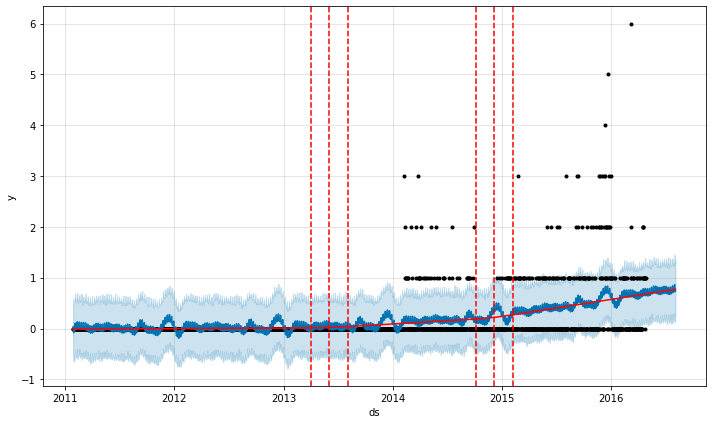

In [177]:
fig = model.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), model, forecast_data) #plot changepoints
# changepoints are only inferred for the first 80% of the time series in order 
# to have runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series

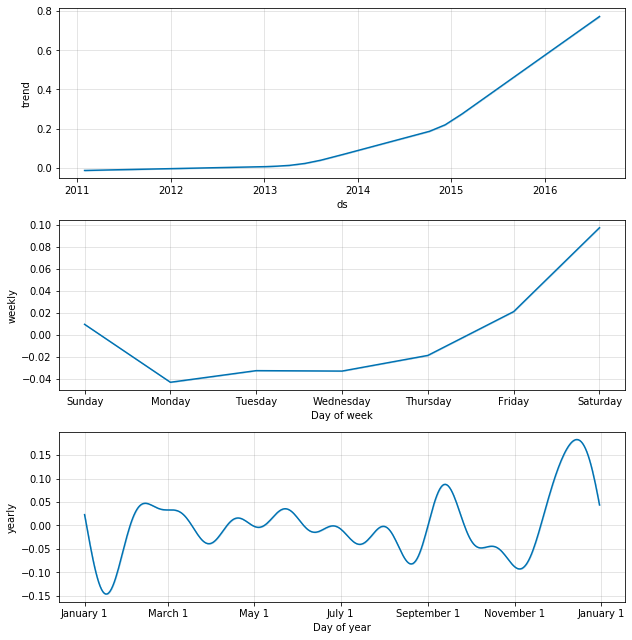

In [178]:
_=model.plot_components(forecast_data)

Prophet plotted the yearly, weekly, and monthly seasonal trends. So far they matches what we have discovered in the EDA section:
- sales are on an upward trajectory
- sales peak on the weekends and in the summer


In [179]:
# view forecasts with original data 
train_data.set_index('ds', inplace=True)
forecast_data.set_index('ds', inplace=True)
train_forecast_data=train_data.join(forecast_data[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
train_forecast_data

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2011-01-29,0.0,0.034199,-0.513634,0.592879
2011-01-30,0.0,-0.042174,-0.594617,0.503152
2011-01-31,0.0,-0.083651,-0.653999,0.490867
2011-02-01,0.0,-0.062221,-0.588547,0.488103
2011-02-02,0.0,-0.052377,-0.631510,0.521014
...,...,...,...,...
2016-07-29,NaN,0.785061,0.223291,1.349250
2016-07-30,NaN,0.863511,0.301759,1.452673
2016-07-31,NaN,0.776809,0.260853,1.368865


In [180]:
#get the last date in the train data set
last_date=train_data.index[-1]
print(last_date)

2016-04-24 00:00:00


In [189]:
# plot forecasted data with original sales data
from datetime import date, timedelta

def plot_data(func_df, start_date, end_date):
    start_date='2016-01-01'
    start_mask=(func_df.index >start_date)
    end_date = end_date-timedelta(days=1) #find the 2nd to last row in the original data
    end_mask = (func_df.index > end_date) # pull out the predicted rows of data
    historic_data=func_df.loc[start_mask] #create new dataframe from 2016 onwards
    predict_data = func_df.loc[end_mask] # create new dataframe of the predicted values
    
    #plot
    ax1 = plt.figure(figsize=(12, 5)).gca()
    ax1.plot(historic_data.y, color='orange')
    ax1.plot(predict_data.yhat, color='black', linestyle=':')
    ax1.fill_between(predict_data.index, predict_data['yhat_upper'], predict_data['yhat_lower'], alpha=0.5, color='darkgray')
    ax1.set_title('Sales (Orange for Historic and Black for Forecast)')
    ax1.set_ylabel('Sales')
    ax1.set_xlabel('Date')

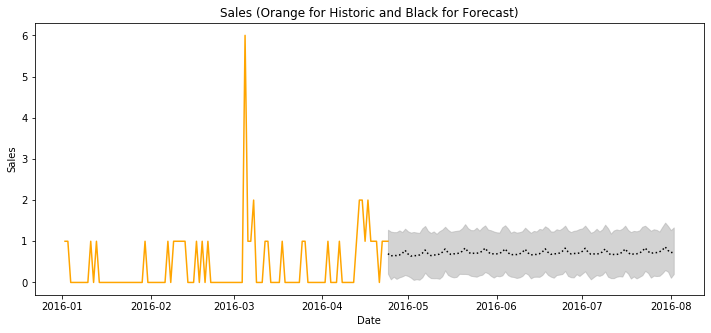

In [190]:
plot_data(train_forecast_data, '2016-01-01', last_date)

### Apply the model for one item

In [161]:
# Format data to fit prophet 

In [166]:
HOBBIES_1_003_CA_1 = sales_train.loc[sales_train['id'] == 'HOBBIES_1_003_CA_1_validation']
HOBBIES_1_003_CA_1

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [168]:
HOBBIES_1_003_CA_1_trans=pd.wide_to_long(HOBBIES_1_003_CA_1, stubnames='d_', i=['id','item_id','dept_id','cat_id','store_id','state_id'], j='day').reset_index()
HOBBIES_1_003_CA_1_trans.rename(columns={'d_':'sales'}, inplace=True)
HOBBIES_1_003_CA_1_trans.tail(20)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
1893,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1894,0
1894,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1895,0
1895,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1896,1
1896,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1897,0
1897,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1898,0
1898,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1899,0
1899,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1900,0
1900,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1901,0
1901,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1902,1
1902,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1903,2


In [169]:
HOBBIES_1_003_CA_1_merged=pd.merge(HOBBIES_1_003_CA_1_trans, calendar, left_on='day', right_on='d', how='left')

In [170]:
HOBBIES_1_003_CA_1_merged.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,wm_yr_wk,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,1,nan,nan,nan,nan,0,0,0
1,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,2,0,2011-01-30,11101,...,1,2011,2,nan,nan,nan,nan,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,3,0,2011-01-31,11101,...,1,2011,3,nan,nan,nan,nan,0,0,0
3,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,4,0,2011-02-01,11101,...,2,2011,4,nan,nan,nan,nan,1,1,0
4,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,5,0,2011-02-02,11101,...,2,2011,5,nan,nan,nan,nan,1,0,1


In [171]:
# Apply prophet
train_data=HOBBIES_1_003_CA_1_merged[['date','sales']].copy()
train_data.rename(columns={"date":'ds', "sales":"y"}, inplace=True)